# Setup

In [1]:
import json
import os
import sys

sys.path.append('..')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors as plt_colors
import seaborn as sns

from sklearn.metrics import mean_absolute_error, balanced_accuracy_score, root_mean_squared_error
from custom_metrics import mean_absolute_error_range

from utils import read_csv_non_utf, ratios_to_DI_cats

In [2]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']
ferreiro_arias2024 = config['indiv_data_paths']['ferreiro_arias2024']

ben_lop_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)
fer_ari_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, ferreiro_arias2024)

In [3]:
# Choosing the dataset - "mammals" or "birds"
dataset = 'mammals'

# Reading in the dataset
if dataset == 'birds':
    data = pd.read_csv(fer_ari_path)
elif dataset == 'mammals':
    data = read_csv_non_utf(ben_lop_path)

data.head()

,Reference,Study,Order,Family,Species,ratio,RR,X,Y,Region,Country,BM,Diet,DistKm,Reserve,TravTime,LivestockBio,Stunting,PopDens,Literacy
0,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.377193,-0.974594,9.839,-1.916,Africa,Gabon,17.07,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
1,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.865690,-0.144053,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
2,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.833333,-0.182139,9.839,-1.916,Africa,Gabon,17.07,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
3,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.900862,-0.104234,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
4,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.956140,-0.044691,9.839,-1.916,Africa,Gabon,17.07,Herb,0.60,No,755.8,39.25948,22.0,0.86,81.8


In [4]:
# Establishing a consistent naming scheme and color palette
model_names_plot = {'FLAML_classification_2mins' : {'name' : 'Nonlinear Classification', 
                                                    'color' : '#ef476f'}, 
                    'FLAML_regression_2mins' : {'name' : 'Nonlinear Regression',
                                                'color' : '#f78c6b'},
                    'sklearn_hurdle' : {'name' : 'Linear Fixed-Effects Hurdle',
                                        'color' : '#97c1a9'},
                    'pymer_hurdle_w_rfx' : {'name' : 'Linear Mixed-Effects Hurdle (w/rfx)',
                                            'color' : '#ffd166'},
                    'pymer_hurdle_wo_rfx' : {'name' : 'Linear Mixed-Effects Hurdle (w/o rfx)',
                                             'color' : '#06d6a0'},
                    'FLAML_hurdle_2mins' : {'name' : 'Nonlinear Hurdle',
                                            'color' : '#118ab2'},
                    'dummy_regressor' : {'name' : 'Naïve Regressor',
                                        'color' : '#073b4c'},
                    'FLAML_hurdle_3mins_BioCLIP+SatCLIP' : {'name' : 'Nonlinear Hurdle (w/embeddings)', 
                                                            'color' : '#c175c7'},
                    'FLAML_hurdle_3mins_JUST_BioCLIP+SatCLIP' : {'name' : 'Nonlinear Hurdle (just embeddings)', 
                                                                 'color' : '#d9c875'}, 
                    'FLAML_hurdle_2mins_both' : {'name' : 'Nonlinear Hurdle (both datasets)',
                                                 'color' : '#f09089'}
                   }
metric_names_plot = {'balanced_accuracy_overall' : 'Balanced Accuracy$\\uparrow$',
                     'mean_absolute_error' : 'Mean Absolute Error$\\downarrow$',
                     'mean_absolute_error_0-1' : 'Mean Absolute Error\n(0-1 range)$\\downarrow$',
                     'root_mean_squared_error' : 'Root Mean Squared Error$\\downarrow$'}

# Cross-validation: pre-computed metrics

These are the metrics that I computed and saved as a CSV during cross-validation.

In [5]:
# Load back in cross-val resuls
save_fp = '/Users/emiliolr/Desktop/life-hunting/results'
cv_results = pd.read_csv(os.path.join(save_fp, 'cross_val_results.csv'))

#  choosing metrics to inspect
metrics_to_keep = ['balanced_accuracy_overall', 'mean_absolute_error', 'mean_absolute_error_0-1', 'root_mean_squared_error']
cv_results = cv_results[(cv_results['metric'].isin(metrics_to_keep)) & (cv_results['dataset'] == dataset)]

#  keeping only one entry for each model run, if there are duplicates
num_obs = cv_results.shape[0]

dup_cols = ['DI_category', 'metric', 'model_name', 'dataset', 'num_folds', 
            'block_type', 'spatial_spacing', 'group_col']
cv_results = cv_results.sort_values('date', ascending = True).drop_duplicates(dup_cols, keep = 'last') # using most recent

print(f'{num_obs - cv_results.shape[0]} duplicate rows excluded')

#  only inspecting group blocking by species
cv_results = cv_results[(cv_results['group_col'] == 'Species') | (cv_results['block_type'].isin(['random', 'spatial']))]

#  grabbing only the needed columns
cols_to_keep = ['metric', 'mean', 'standard_deviation', 'model_name', 'block_type', 'group_col']
cv_results = cv_results[cols_to_keep]

12 duplicate rows excluded


In [6]:
# Load multi-taxa modelling results
col_names = ['metric', 'mean', 'standard_deviation', 'model_name', 'block_type', 'group_col']
metrics_dict = {'birds' : [], 'mammals' : []}

model_name = 'FLAML_hurdle_2mins_both'
fps = ['FLAML_hurdle_2mins_both_5-fold_random-blocking.csv',
       'FLAML_hurdle_2mins_both_5-fold_spatial-blocking_5-degree.csv',
       'FLAML_hurdle_2mins_both_5-fold_group-blocking_species.csv']
block = ['random', 'spatial', 'group']

#  compute metrics in the same way as before
for fp, b in zip(fps, block):
    data = pd.read_csv(f'../results/raw_predictions/{fp}')

    group_col = 'Species' if b == 'group' else None

    for d in ['mammals', 'birds']:
        data_sub = data[data['dataset'] == d]
        data_sub = data_sub.groupby('fold')

        mae = data_sub.apply(lambda r: mean_absolute_error(r['actual'], r['predicted']), include_groups = False)
        metrics_dict[d].append(['mean_absolute_error', mae.mean(), mae.std(), model_name, b, group_col])

        mae_01 = data_sub.apply(lambda r: mean_absolute_error_range(r['actual'], r['predicted'], 0, 1)[0], include_groups = False)
        metrics_dict[d].append(['mean_absolute_error_0-1', mae_01.mean(), mae_01.std(), model_name, b, group_col])

        rmse = data_sub.apply(lambda r: root_mean_squared_error(r['actual'], r['predicted']), include_groups = False)
        metrics_dict[d].append(['root_mean_squared_error', rmse.mean(), rmse.std(), model_name, b, group_col])

        ba = data_sub.apply(lambda r: balanced_accuracy_score(ratios_to_DI_cats(r['actual']), ratios_to_DI_cats(r['predicted'])), include_groups = False)
        metrics_dict[d].append(['balanced_accuracy_overall', ba.mean(), ba.std(), model_name, b, group_col])

#  adding to the existing dataset
df_both = pd.DataFrame(metrics_dict[dataset], columns = col_names)
cv_results = pd.concat((cv_results, df_both), axis = 0)

cv_results = cv_results.sort_values(by = ['block_type', 'model_name', 'metric'])
cv_results.head()

,metric,mean,standard_deviation,model_name,block_type,group_col
211,balanced_accuracy_overall,0.563585,0.010078,FLAML_classification_2mins,group,Species
403,balanced_accuracy_overall,0.511460,0.032982,FLAML_hurdle_2mins,group,Species
404,mean_absolute_error,0.809448,0.125711,FLAML_hurdle_2mins,group,Species
405,mean_absolute_error_0-1,0.309167,0.025149,FLAML_hurdle_2mins,group,Species
406,root_mean_squared_error,3.406656,1.715946,FLAML_hurdle_2mins,group,Species


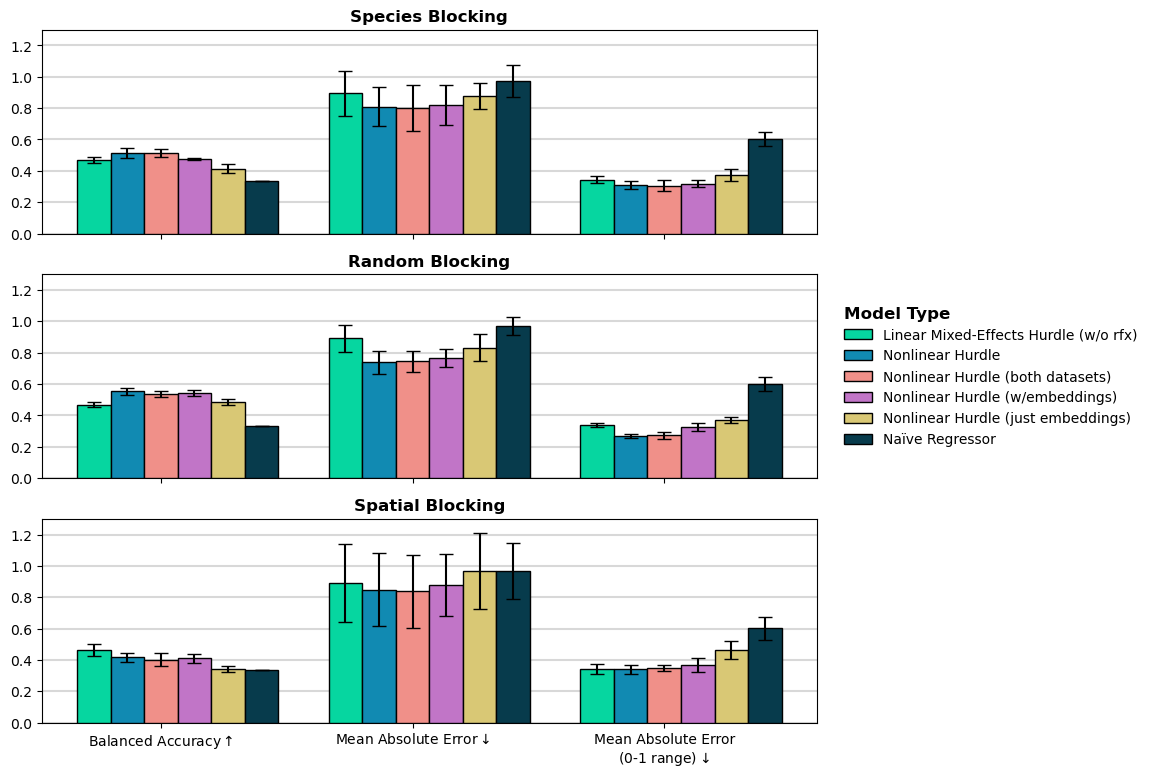

In [12]:
# Plotting results for the above metrics
plot_just_hurdles = True
plot_rmse = False
width = 0.8

metrics = sorted(cv_results[cv_results['model_name'] == 'FLAML_hurdle_2mins']['metric'].unique())
if not plot_rmse:
    metrics.remove('root_mean_squared_error')

blocks = cv_results['block_type'].unique()
if plot_just_hurdles:
    models = ['pymer_hurdle_wo_rfx', 'FLAML_hurdle_2mins', 'FLAML_hurdle_2mins_both']
    if dataset == 'mammals':
        models += ['FLAML_hurdle_3mins_BioCLIP+SatCLIP', 'FLAML_hurdle_3mins_JUST_BioCLIP+SatCLIP']
    models += ['dummy_regressor']
else:
    models = ['FLAML_classification_2mins', 'FLAML_regression_2mins', 'pymer_hurdle_w_rfx', 
              'pymer_hurdle_wo_rfx', 'FLAML_hurdle_2mins', 'dummy_regressor']

fig, axs = plt.subplots(3, 1, figsize = (10, 9), sharex = True)

for i, block in enumerate(blocks):
    ax = axs[i]

    ind = np.arange(len(metrics))
    multiplier = 0
    
    for i, model in enumerate(models):
        model_results = cv_results[(cv_results['model_name'] == model) & (cv_results['block_type'] == block) & (cv_results['metric'].isin(metrics))]
        
        means = list(model_results['mean'])
        stds = list(model_results['standard_deviation'])
    
        if model.startswith('FLAML_classification'):
            means.extend([np.nan] * (len(metrics) - 1))
            stds.extend([np.nan] * (len(metrics) - 1))
    
        position = ind + (width / len(models)) * multiplier 
        
        ax.bar(position, means, width / len(models), yerr = stds, capsize = 5, edgecolor = 'black', 
               color = model_names_plot[model]['color'], label = model_names_plot[model]['name'], zorder = 100)
    
        multiplier += 1
    
    ax.set_xticks(ind + (width / 2) - (width / len(models)))
    ax.set_xticklabels([metric_names_plot[m] for m in metrics])

    block_name = 'species' if block == 'group' else block    
    ax.set_title(f'{block_name} blocking'.title(), weight = 'bold', size = 12, pad = 6)
    
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    ax.grid(visible = True, which = 'major', axis = 'y', color = 'grey', zorder = 0, linewidth = 1.5,
            alpha = 0.3)
    ax.set_ylim((0, 1.3))

legend = axs[1].legend(loc = 'center right', bbox_to_anchor = (1.43, 0.5), ncols = 1, frameon = False,
                       title = 'Model Type', title_fontproperties = {'weight' : 'bold', 'size' : 12})
legend._legend_box.align = 'left'

# plt.savefig(f'../figures/cv_results_all_blocking_{dataset}_{'just_hurdles' if plot_just_hurdles else 'all_models'}.pdf', bbox_inches = 'tight', dpi = 300)
plt.show()

In [60]:
# Highlighting percent improvement in metrics betweeen non-linear vs. linear mixed effects (w/rfx) hurdle
models_to_inspect = ['FLAML_hurdle_2mins', 'pymer_hurdle_wo_rfx', 'dummy_regressor']
to_compare = [(0, 1), (0, 2)]

if dataset == 'mammals':
    models_to_inspect += ['FLAML_hurdle_3mins_JUST_BioCLIP+SatCLIP']
    to_compare += [(3, 1), (3, 2)]

cv_subset = cv_results[cv_results['model_name'].isin(models_to_inspect)]

for block in blocks:
    block_name = 'species' if block == 'group' else block  
    print_str = f'{block_name.upper()} BLOCKING'
    print(print_str)
    print('-' * len(print_str))

    #  getting the desired metric values for each model
    model_metrics = {m : {} for m in models_to_inspect}
    for metric in metrics_to_keep:
        mask = (cv_subset['metric'] == metric) & (cv_subset['block_type'] == block)

        for m in models_to_inspect:
            model_metrics[m][metric] = cv_subset[mask & (cv_subset['model_name'] == m)]['mean'].iloc[0]

    #  making the desired comparisons
    for comp in to_compare:
        model_a, model_b = models_to_inspect[comp[0]], models_to_inspect[comp[1]]
        print_str = f'{model_a} vs. {model_b}:'
        print('   ' + print_str)
        print('   ' + '-' * len(print_str))
        
        for metric in metrics_to_keep:
            val_a = model_metrics[model_a][metric]
            val_b = model_metrics[model_b][metric]

            pct_diff = round(((val_a - val_b) / val_b) * 100, 2)
            if pct_diff > 0:
                pct_diff = '+' + str(pct_diff) 

            print(f'   {metric}: {pct_diff}%')
        print()
    print()

SPECIES BLOCKING
----------------
   FLAML_hurdle_2mins vs. pymer_hurdle_wo_rfx:
   -------------------------------------------
   balanced_accuracy_overall: +9.19%
   mean_absolute_error: -9.38%
   mean_absolute_error_0-1: -10.13%
   root_mean_squared_error: -1.93%

   FLAML_hurdle_2mins vs. dummy_regressor:
   ---------------------------------------
   balanced_accuracy_overall: +53.44%
   mean_absolute_error: -16.73%
   mean_absolute_error_0-1: -48.59%
   root_mean_squared_error: +0.53%

   FLAML_hurdle_3mins_JUST_BioCLIP+SatCLIP vs. pymer_hurdle_wo_rfx:
   ----------------------------------------------------------------
   balanced_accuracy_overall: -11.59%
   mean_absolute_error: -1.83%
   mean_absolute_error_0-1: +8.04%
   root_mean_squared_error: -0.97%

   FLAML_hurdle_3mins_JUST_BioCLIP+SatCLIP vs. dummy_regressor:
   ------------------------------------------------------------
   balanced_accuracy_overall: +24.23%
   mean_absolute_error: -9.79%
   mean_absolute_error_0-1: -38

## Simplifying the plot for the MRes presentation

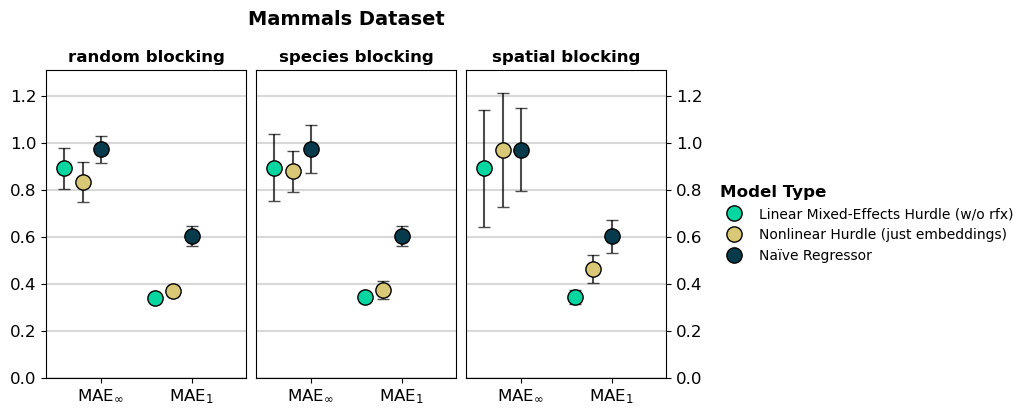

In [48]:
include_embeddings = True
models = ['pymer_hurdle_wo_rfx', 'FLAML_hurdle_2mins', 'dummy_regressor']
if include_embeddings and dataset == 'mammals':
    models = ['pymer_hurdle_wo_rfx', 'FLAML_hurdle_3mins_JUST_BioCLIP+SatCLIP', 'dummy_regressor']

blocks = ['random', 'group', 'spatial']
metrics = sorted(['mean_absolute_error', 'mean_absolute_error_0-1'])

cv_results_sub = cv_results[cv_results['model_name'].isin(models) & 
                            cv_results['block_type'].isin(blocks) & 
                            cv_results['metric'].isin(metrics)]

jitters = [-0.2, 0, 0.2]
if include_embeddings:
    jitters = [-0.4, -0.2, 0, 0.2, 0.4]

fig, axs = plt.subplots(1, len(blocks), figsize = (8, 4), sharey = True)

for i, block in enumerate(blocks):
    ax = axs[i]
    
    for model, jitter in zip(models, jitters):
        cv_model = cv_results_sub[(cv_results_sub['model_name'] == model) & (cv_results_sub['block_type'] == block)]
    
        x_loc = [0 + jitter, 1 + jitter]
        _, caps, bars = ax.errorbar(x_loc, cv_model['mean'], yerr = cv_model['standard_deviation'], 
                                    color = model_names_plot[model]['color'], fmt = 'o', ecolor = 'black', capsize = 4,
                                    markeredgecolor = 'black', markersize = 11, label = model_names_plot[model]['name'])
    
        alpha = 0.7
        [bar.set_alpha(alpha) for bar in bars]
        [cap.set_alpha(alpha) for cap in caps]

    title = 'species' if block == 'group' else block
    ax.set_title(f'{title} blocking', weight = 'bold')

    metric_names = ['MAE$_\\infty$', 'MAE$_1$']
    ax.set_xticks(ticks = [0, 1], labels = metric_names)
    ax.tick_params(labelsize = 12)

    ax.grid(visible = True, which = 'major', axis = 'y', color = 'grey', zorder = 0, linewidth = 1.5,
            alpha = 0.3)

    max_sub = cv_results_sub[cv_results_sub['metric'] == 'mean_absolute_error']
    max_val = (max_sub['mean'] + max_sub['standard_deviation']).max()
    ax.set_ylim((0, max_val + 0.1))

    if not include_embeddings:
        ax.set_xlim((-0.6, 1.6))
    else:
        ax.set_xlim((-0.6, 1.6))

#  adding a legend and removing error bars
axs[-1].legend()
handles, labels = axs[-1].get_legend_handles_labels()
handles = [h[0] for h in handles]

legend = axs[-1].legend(handles, labels, loc = 'center right', bbox_to_anchor = (2.8, 0.5), ncols = 1, frameon = False,
                        title = 'Model Type', title_fontproperties = {'weight' : 'bold', 'size' : 12})
legend._legend_box.align = 'left'

#  tweaking ticks between the subplots
axs[-1].tick_params(right = True, left = False, labelright = True)

for ax in axs[1 : -1]:
    ax.tick_params(right = False, left = False)

#  adjusting spacing
fig.subplots_adjust(wspace = 0.05)

fig.suptitle(f'{dataset.title()} Dataset', weight = 'bold', size = 14, y = 1.03)

# plt.savefig(f'../presentation_figures/simplified_model_results_{dataset}{'_w_embeddings' if include_embeddings else ''}.png', bbox_inches = 'tight', dpi = 300)
plt.show()

# Cross-validation: visualizing raw predictions

This uses the raw prediction CSV saves, which contains the prediction for each data point when it appeared in the test set--for cross-validation, this of course happens only once since each data point is in only one fold.

In [41]:
# Reading in raw prediction data
models_to_inspect = ['FLAML_hurdle_2mins', 'pymer_hurdle_wo_rfx']
block = 'random'

#  tweaking the naming to match the convention I adopted while saving predictions
if block == 'random':
    block_name = 'random-blocking'
elif block == 'species':
    block_name = 'group-blocking_species'
elif block == 'spatial':
    block_name = 'spatial-blocking_5-degree'

#  reading in the data
raw_preds_fp = os.path.join(save_fp, 'raw_predictions')
raw_preds = {}
for model in models_to_inspect:
    fp = os.path.join(raw_preds_fp, f'{model}_{dataset}_5-fold_{block_name}.csv')
    preds = pd.read_csv(fp)

    #  getting absolute errors
    preds['abs_error'] = np.abs(preds['actual'] - preds['predicted'])
    
    #  adding to the dict
    raw_preds[model] = preds

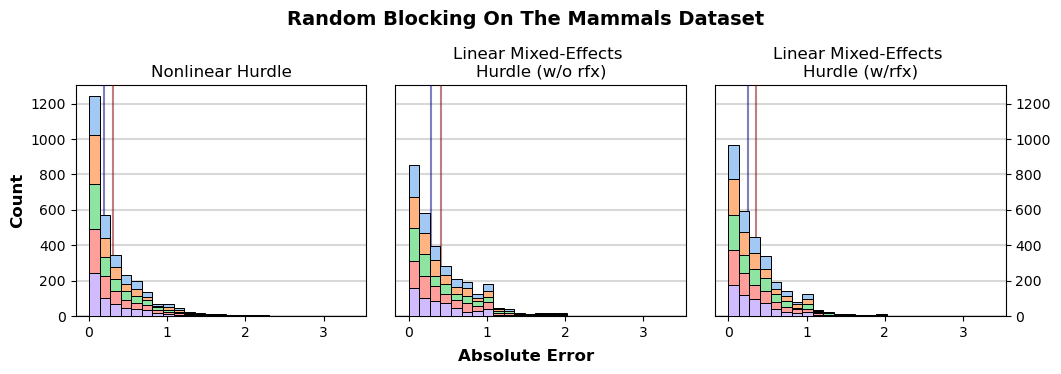

In [39]:
# Plotting the distribution of absolute errors
max_val = 2

fig, axs = plt.subplots(1, len(models_to_inspect), figsize = (12, 3), sharey = True)

# Grabbing the largest value to ensure the histograms have the same bin range (for AE plotting)
largest_ae = np.max([np.max(raw_preds[m][raw_preds[m]['actual'] < max_val]['abs_error']) for m in models_to_inspect])

# Plotting for each model
for ax, model in zip(axs, models_to_inspect):
    data = raw_preds[model]
    data = data[data['actual'] <= max_val]

    #  plotting distribution of AEs
    sns.histplot(data = data, x = 'abs_error', stat = 'count', multiple = 'stack', kde = False,
                 hue = 'fold', legend = False, bins = 25, binrange = (0, largest_ae), palette = 'pastel',
                 zorder = 100, alpha = 1, ax = ax)

    #  adding vertical lines for mean and median
    mean, median = data['abs_error'].mean(), data['abs_error'].median()
    
    ax.axvline(x = mean, zorder = 50, color = 'maroon', alpha = 0.5, label = 'mean')
    ax.axvline(x = median, zorder = 50, color = 'navy', alpha = 0.5, label = 'median')
    
    #  cleaning up labelling
    title = model_names_plot[model]['name']
    if '(' in title:
        title = title.split('Hurdle')
        title = title[0] + '\n' + 'Hurdle' + title[1]
    
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('Count', weight = 'bold', size = 12)

    ax.grid(visible = True, which = 'major', axis = 'y', color = 'grey', zorder = 0, linewidth = 1.5, alpha = 0.3)

#  fiddling with the y-ticks
axs[-1].tick_params(right = True, left = False, labelright = True)

for ax in axs[1 : -1]:
    ax.tick_params(right = False, left = False)

#  adjusting spacing
fig.subplots_adjust(wspace = 0.1)

#  adding an overall title
fig.suptitle(f'{block} blocking on the {dataset} dataset'.title(), weight = 'bold', y = 1.13, size = 14)
fig.supxlabel('Absolute Error', weight = 'bold', y = -0.05, size = 12)

plt.show()

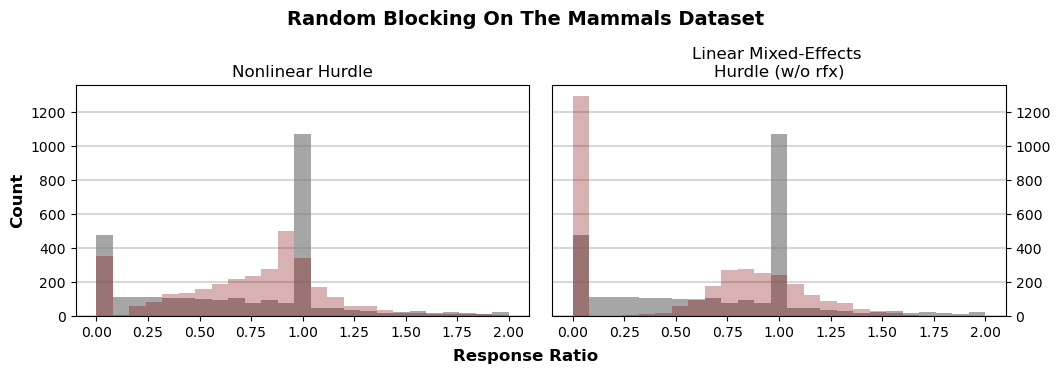

In [45]:
# Plotting ratio distributions
max_val = 2

fig, axs = plt.subplots(1, len(models_to_inspect), figsize = (12, 3), sharey = True)

actual = raw_preds['FLAML_hurdle_2mins']
actual = actual[actual['actual'] <= max_val]

# Plotting for each model
for ax, model in zip(axs, models_to_inspect):
    data = raw_preds[model]

    #  we just look at how things are distributed in this range--not necessarily the case that the
    #   predictions themselves align w/actual, just that the distribution of ratios is even reasonable
    data = data[data['predicted'] <= max_val]

    #  plotting model distribution
    sns.histplot(data = data, x = 'predicted', stat = 'count', kde = False, legend = False, bins = 25, 
                 color = 'maroon', zorder = 100, alpha = 0.3, ec = None, binrange = (0, max_val), ax = ax)
    
    #  plotting greyed-out actual distribution for reference
    sns.histplot(data = actual, x = 'actual', stat = 'count', kde = False, legend = False, bins = 25, 
                 color = 'grey', zorder = 20, alpha = 0.7, ec = None, binrange = (0, max_val), ax = ax)

    #  adding a vertical line for mean and median
    mean_pred, mean_actual = data['predicted'].mean(), actual['actual'].mean()
    
    # ax.axvline(x = mean_pred, zorder = 50, color = 'maroon', alpha = 1)
    # ax.axvline(x = mean_actual, zorder = 50, color = 'grey', alpha = 1)

    #  cleaning up labelling
    title = model_names_plot[model]['name']
    if '(' in title:
        title = title.split('Hurdle')
        title = title[0] + '\n' + 'Hurdle' + title[1]
    
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('Count', weight = 'bold', size = 12)

    ax.grid(visible = True, which = 'major', axis = 'y', color = 'grey', zorder = 0, linewidth = 1.5, alpha = 0.3)

#  fiddling with the y-ticks
axs[-1].tick_params(right = True, left = False, labelright = True)

for ax in axs[1 : -1]:
    ax.tick_params(right = False, left = False)

#  adjusting the spacing between plots
fig.subplots_adjust(wspace = 0.05)

#  adding an overall title
fig.suptitle(f'{block} blocking on the {dataset} dataset'.title(), weight = 'bold', y = 1.13, size = 14)
fig.supxlabel('Response Ratio', weight = 'bold', y = -0.05, size = 12)

# plt.savefig(f'../presentation_figures/cv_abundance_distribution_hurdles_{dataset}_{block}.png', bbox_inches = 'tight', dpi = 300)
plt.show()

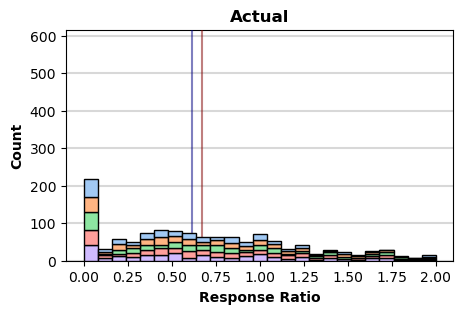

In [197]:
# Plotting the distribution of actual ratios, to be added into the figure later
plt.figure(figsize = (5, 3))

sns.histplot(data = actual, x = 'actual', stat = 'count', multiple = 'stack', kde = False, hue = 'fold', 
             legend = False, bins = 25, palette = 'pastel', zorder = 100, alpha = 1, ec = 'black', 
             binrange = (0, max_val))

mean, median = actual['actual'].mean(), actual['actual'].median()

plt.axvline(x = mean, zorder = 50, color = 'maroon', alpha = 0.5)
plt.axvline(x = median, zorder = 50, color = 'navy', alpha = 0.5)

plt.title('Actual', weight = 'bold')
plt.xlabel('Response Ratio', weight = 'bold')
plt.ylabel('Count', weight = 'bold')

plt.ylim(axs[0].get_ylim())

plt.grid(visible = True, which = 'major', axis = 'y', color = 'grey', zorder = 0, linewidth = 1.5, alpha = 0.3)

# plt.savefig(f'../figures/cv_abundance_distribution_actual_{dataset}_{block}.pdf', bbox_inches = 'tight', dpi = 300)
plt.show()

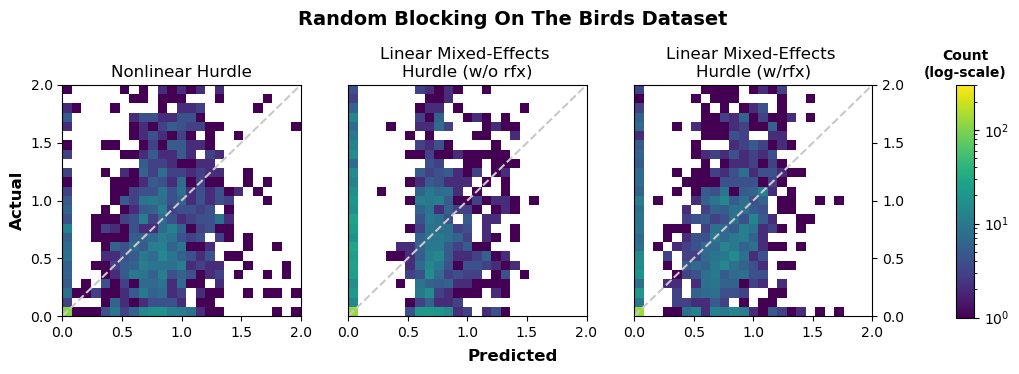

In [198]:
# Plotting a 2D histogram to show the joint distribution of actual vs. predicted
max_val = 2

fig, axs = plt.subplots(1, len(models_to_inspect), figsize = (12, 3), sharey = True)

actual = raw_preds['FLAML_hurdle_2mins']
actual = actual[actual['actual'] <= max_val]

# Plotting for each model
for ax, model in zip(axs, models_to_inspect):
    data = raw_preds[model]

    #  setting the min and max here is super important to be sure that the colormaps
    #   are all on the same scaler
    norm = plt_colors.LogNorm(vmin = 1, vmax = 300)

    #  plotting 2D histogram
    h = ax.hist2d(data['predicted'], data['actual'], bins = 25, norm = norm,
                  range = [[0, max_val], [0, max_val]])  

    #  plotting 1:1 line for reference
    ax.axline((0, 0), slope = 1, color = '#c9c9c9', linestyle = '--')


    title = model_names_plot[model]['name']
    if '(' in title:
        title = title.split('Hurdle')
        title = title[0] + '\n' + 'Hurdle' + title[1]
    
    ax.set_title(title)
    ax.set_xlabel('')
    
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)

axs[0].set_ylabel('Actual', weight = 'bold', size = 12)

#  adding the colorbar on the side
fig.subplots_adjust(right = 0.8)
cbar_ax = fig.add_axes([0.87, 0.105, 0.015, 0.775])
cbar = fig.colorbar(h[3], cax = cbar_ax)
cbar.ax.set_title('Count\n(log-scale)', weight = 'bold', size = 10)

#  fiddling with the y-ticks
axs[-1].tick_params(right = True, left = False, labelright = True)

for ax in axs[1 : -1]:
    ax.tick_params(right = False, left = False)

axs[-1].set_yticks(axs[-1].get_xticks())

#  adding an overall title
fig.suptitle(f'{block} blocking on the {dataset} dataset'.title(), weight = 'bold', y = 1.13, size = 14)
fig.supxlabel('Predicted', weight = 'bold', y = -0.05, size = 12)

# plt.savefig(f'../figures/cv_actual_vs_predicted_hurdles_{dataset}_{block}.pdf', bbox_inches = 'tight', dpi = 300)
plt.show()

# Extreme generalization

These are the results from the experiments in `extreme_generalisation.ipynb`.

## Cross-taxa

In [64]:
# Pulling in the data
models = ['dummy_regressor', 'FLAML_hurdle_5mins', 'pymer_hurdle_wo_rfx']

base_fp = '../results/raw_predictions'
bird_file_pattern = '%s_SPECIAL_mammals-->birds.csv'
mammal_file_pattern = '%s_SPECIAL_birds-->mammals.csv'

bird_results = []
mammal_results = []

for model in models:
    bird_fp = os.path.join(base_fp, bird_file_pattern % model)
    bird_data = pd.read_csv(bird_fp)
    
    mammal_fp = os.path.join(base_fp, mammal_file_pattern % model)
    mammal_data = pd.read_csv(mammal_fp)

    for data, results in zip([bird_data, mammal_data], [bird_results, mammal_results]):
        y_test, y_pred = data['actual'], data['predicted']
        true_DI_cats, pred_DI_cats = ratios_to_DI_cats(y_test), ratios_to_DI_cats(y_pred)
        
        mae = mean_absolute_error(y_test, y_pred)
        mae_01, _ = mean_absolute_error_range(y_test, y_pred, 0, 1)
        rmse = root_mean_squared_error(y_test, y_pred)
        ba = balanced_accuracy_score(true_DI_cats, pred_DI_cats)

        results.append([mae, mae_01, rmse, ba, model])

metric_cols = ['mean_absolute_error', 'mean_absolute_error_0-1', 'root_mean_squared_error', 'balanced_accuracy_overall']
cols = metric_cols + ['model_name']
bird_results = pd.DataFrame(bird_results, columns = cols)
mammal_results = pd.DataFrame(mammal_results, columns = cols)

val_vars = set(cols) - set(['model_name'])
bird_results = bird_results.melt(id_vars = ['model_name'], value_vars = val_vars, var_name = 'metric').sort_values(by = ['model_name', 'metric'])
mammal_results = mammal_results.melt(id_vars = ['model_name'], value_vars = val_vars, var_name = 'metric').sort_values(by = ['model_name', 'metric'])

bird_results['model_name'] = bird_results['model_name'].replace({'FLAML_hurdle_5mins' : 'FLAML_hurdle_2mins'})
mammal_results['model_name'] = mammal_results['model_name'].replace({'FLAML_hurdle_5mins' : 'FLAML_hurdle_2mins'})

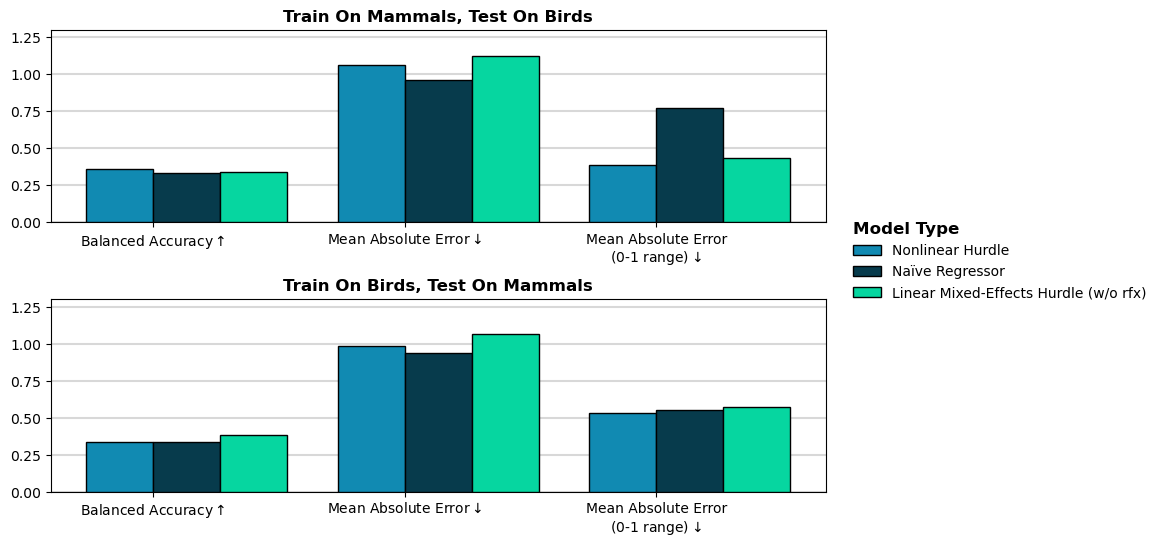

In [67]:
# Plotting results for cross-taxa generalization
plot_rmse = False
width = 0.8

metrics = sorted(metric_cols)
if not plot_rmse:
    metrics.remove('root_mean_squared_error')

models = bird_results['model_name'].unique()

fig, axs = plt.subplots(2, 1, figsize = (10, 6))

for i, (results, name) in enumerate(zip([bird_results, mammal_results], ['birds', 'mammals'])):
    ax = axs[i]

    ind = np.arange(len(metrics))
    multiplier = 0
    
    for i, model in enumerate(models):
        model_results = results[(results['model_name'] == model) & (results['metric'].isin(metrics))]
        
        values = model_results['value']
    
        position = ind + (width / len(models)) * multiplier 
        
        ax.bar(position, values, width / len(models), edgecolor = 'black', color = model_names_plot[model]['color'], 
               label = model_names_plot[model]['name'], zorder = 100)
    
        multiplier += 1
    
    ax.set_xticks(ind + (width / 2) - (width / len(models)))
    ax.set_xticklabels([metric_names_plot[m] for m in metrics])

    ax.set_title(f'Train on {"birds" if name == "mammals" else "mammals"}, test on {name}'.title(), weight = 'bold', size = 12, pad = 6)
    
    ax.grid(visible = True, which = 'major', axis = 'y', color = 'grey', zorder = 0, linewidth = 1.5,
            alpha = 0.3)
    ax.set_ylim((0, 1.3))

legend = axs[1].legend(loc = 'center right', bbox_to_anchor = (1.43, 1.2), ncols = 1, frameon = False,
                       title = 'Model Type', title_fontproperties = {'weight' : 'bold', 'size' : 12})
legend._legend_box.align = 'left'

fig.subplots_adjust(hspace = 0.4)

# plt.savefig(f'../presentation_figures/extreme_generalisation_cross_taxa.png', bbox_inches = 'tight', dpi = 300)
plt.show()

## Cross-continent

In [61]:
# Pulling in the data
models = ['dummy_regressor', 'FLAML_hurdle_5mins', 'pymer_hurdle_wo_rfx']
regions = ['Neotropic', 'Indomalayan', 'SAmerica', 'Africa']

base_fp = '../results/raw_predictions'
file_pattern = '%s_SPECIAL_test-region-%s.csv'

results = []

for model in models:
    for region in regions:
        fp = os.path.join(base_fp, file_pattern % (model, region))
        data = pd.read_csv(fp)
        
        y_test, y_pred = data['actual'], data['predicted']
        true_DI_cats, pred_DI_cats = ratios_to_DI_cats(y_test), ratios_to_DI_cats(y_pred)
        
        mae = mean_absolute_error(y_test, y_pred)
        mae_01, _ = mean_absolute_error_range(y_test, y_pred, 0, 1)
        rmse = root_mean_squared_error(y_test, y_pred)
        ba = balanced_accuracy_score(true_DI_cats, pred_DI_cats)

        results.append([mae, mae_01, rmse, ba, model, region])

metric_cols = ['mean_absolute_error', 'mean_absolute_error_0-1', 'root_mean_squared_error', 'balanced_accuracy_overall']
cols = metric_cols + ['model_name', 'region']
results = pd.DataFrame(results, columns = cols)
results['dataset'] = results['region'].replace({'Neotropic' : 'birds', 'Indomalayan' : 'birds',
                                                'SAmerica' : 'mammals', 'Africa' : 'mammals'})

val_vars = set(cols) - set(['model_name', 'region', 'dataset'])
results = results.melt(id_vars = ['model_name', 'dataset', 'region'], value_vars = val_vars, var_name = 'metric').sort_values(by = ['dataset', 'region', 'model_name', 'metric'])

results['model_name'] = results['model_name'].replace({'FLAML_hurdle_5mins' : 'FLAML_hurdle_2mins'})

In [62]:
# Alternate names for plotting
region_plot_name = {'Indomalayan' : 'Indomalayan Realm', 
                    'Neotropic' : 'Neotropical Realm',
                    'SAmerica' : 'South America',
                    'Africa' : 'Africa'}

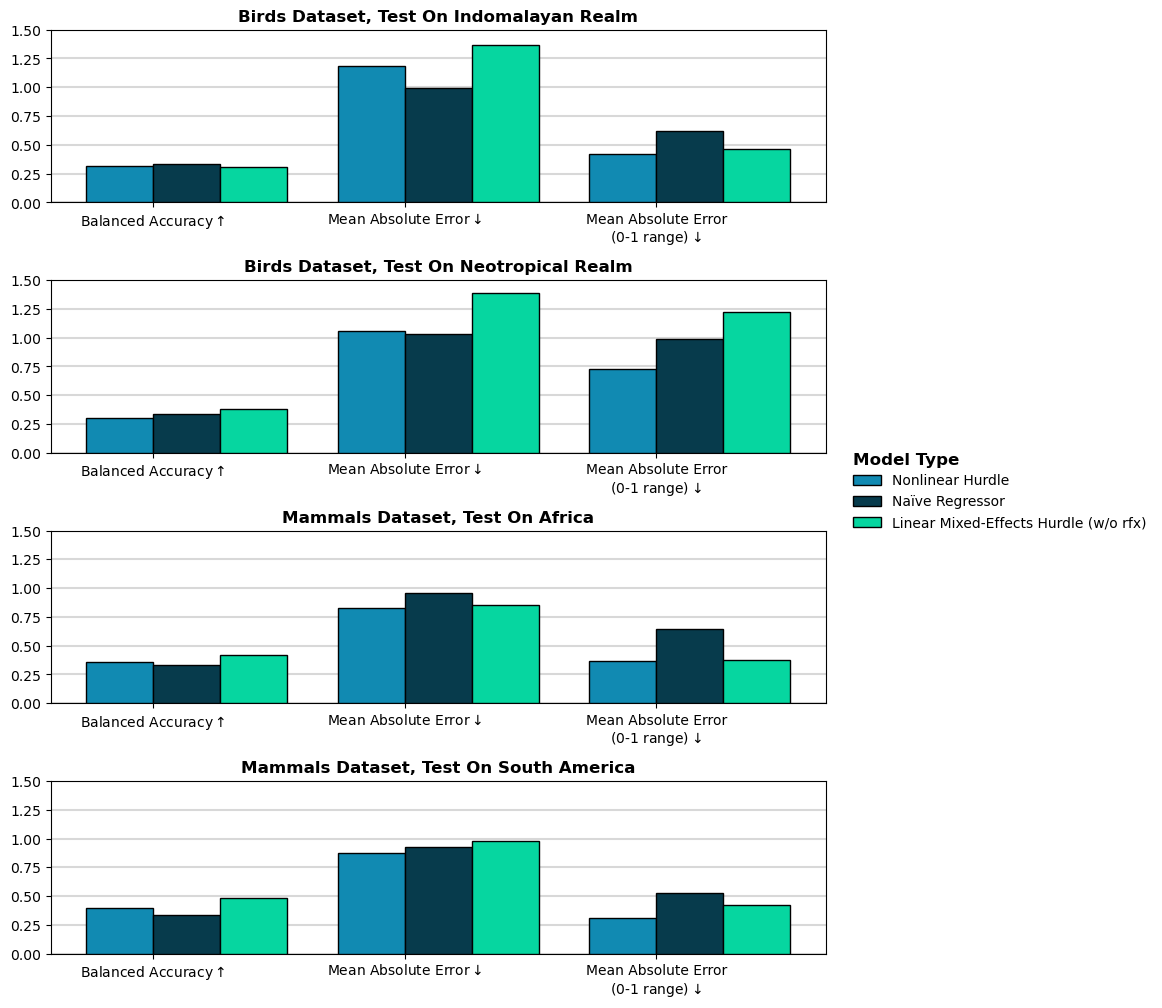

In [63]:
# Plotting results for cross-taxa generalization
plot_rmse = False
width = 0.8

metrics = sorted(metric_cols)
if not plot_rmse:
    metrics.remove('root_mean_squared_error')

models = results['model_name'].unique()
regions = results['region'].unique()

fig, axs = plt.subplots(4, 1, figsize = (10, 12))

for i, region in enumerate(regions):
    ax = axs[i]

    ind = np.arange(len(metrics))
    multiplier = 0
    
    for i, model in enumerate(models):
        model_results = results[(results['model_name'] == model) & (results['region'] == region) & (results['metric'].isin(metrics))]
        
        values = model_results['value']
    
        position = ind + (width / len(models)) * multiplier 
        
        ax.bar(position, values, width / len(models), edgecolor = 'black', color = model_names_plot[model]['color'], 
               label = model_names_plot[model]['name'], zorder = 100)
    
        multiplier += 1
    
    ax.set_xticks(ind + (width / 2) - (width / len(models)))
    ax.set_xticklabels([metric_names_plot[m] for m in metrics])

    dataset = results[results['region'] == region]['dataset'].iloc[0]
    
    ax.set_title(f'{dataset} dataset, test on {region_plot_name[region]}'.title(), weight = 'bold', size = 12, pad = 6)
    
    ax.grid(visible = True, which = 'major', axis = 'y', color = 'grey', zorder = 0, linewidth = 1.5,
            alpha = 0.3)
    ax.set_ylim((0, 1.5))

legend = axs[2].legend(loc = 'center right', bbox_to_anchor = (1.43, 1.23), ncols = 1, frameon = False,
                       title = 'Model Type', title_fontproperties = {'weight' : 'bold', 'size' : 12})
legend._legend_box.align = 'left'

fig.subplots_adjust(hspace = 0.45)

# plt.savefig(f'../presentation_figures/extreme_generalisation_cross_continent.png', bbox_inches = 'tight', dpi = 300)
plt.show()

### Simplifying the plot for the MRes presentation

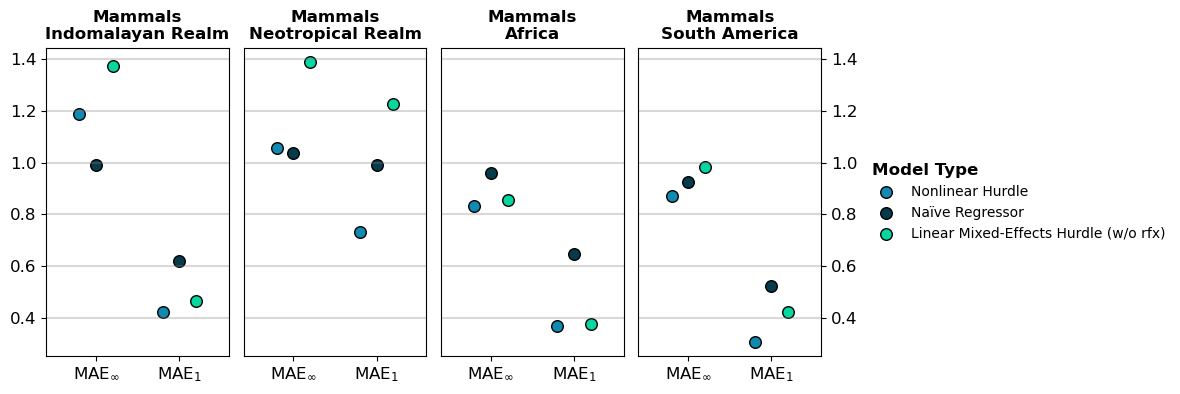

In [24]:
metrics = set(metrics) - set(['balanced_accuracy_overall'])

jitters = [-0.2, 0, 0.2]

fig, axs = plt.subplots(1, 4, figsize = (10, 4), sharey = True)

for i, region in enumerate(regions):
    ax = axs[i]
    
    for model, jitter in zip(models, jitters):
        model_results = results[(results['model_name'] == model) & (results['region'] == region) & (results['metric'].isin(metrics))]
        values = model_results['value']
    
        x_loc = [0 + jitter, 1 + jitter]
        ax.scatter(x_loc, values, color = model_names_plot[model]['color'], edgecolor = 'black',
                   s = 70, label = model_names_plot[model]['name'])

    ax.set_title(f'{dataset.title()}\n{region_plot_name[region]}', weight = 'bold')

    metric_names = ['MAE$_\\infty$', 'MAE$_1$']
    ax.set_xticks(ticks = [0, 1], labels = metric_names)
    ax.tick_params(labelsize = 12)

    ax.grid(visible = True, which = 'major', axis = 'y', color = 'grey', zorder = 0, linewidth = 1.5,
            alpha = 0.3)

    ax.set_xlim((-0.6, 1.6))

#  adding a legend and removing error bars
legend = axs[-1].legend(handles, labels, loc = 'center right', bbox_to_anchor = (2.95, 0.5), ncols = 1, frameon = False,
                        title = 'Model Type', title_fontproperties = {'weight' : 'bold', 'size' : 12})
legend._legend_box.align = 'left'

#  tweaking ticks between the subplots
axs[-1].tick_params(right = True, left = False, labelright = True)

for ax in axs[1 : -1]:
    ax.tick_params(right = False, left = False)

#  adjusting spacing
fig.subplots_adjust(wspace = 0.08)

# plt.savefig(f'../presentation_figures/simplified_model_results_{dataset}{'_w_embeddings' if include_embeddings else ''}.png', bbox_inches = 'tight', dpi = 300)
plt.show()